# Malaria detection with cell images

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage.io import imread

## Fetch data

In [2]:
# On first run, either uncomment this or run fetch_malaria.py as a script.
#from fetch_malaria import fetch_malaria()
#fetch_malaria()

## Load data

Training and test sets are grouped by patient and then shuffled and split with a stable seed. See [Malaria Data Exploration](Malaria%20Data%20Exploration.ipynb).

In [3]:
import load_malaria
labeled_train_meta, _ = load_malaria.load_split_dataset()

In [4]:
labeled_train_meta.shape

(21807, 5)

In [5]:
y_train = np.array(labeled_train_meta['infected'])
groups_train = np.array(labeled_train_meta['patient'])
paths_train = np.array(labeled_train_meta['path'])

## Histogram-based models

After inspecting a small set of positive and negative samples, an obvious first approach is to classify based on a histogram of the image. The staining makes *Plasmodium* cells appear as dark purple spots, which should be easy to detect with a simple model.

In [6]:
X_train = paths_train

In [7]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.base import clone
from cv_utils import cross_val_score_predict

def train_and_evaluate_model(classifier, **whole_fit_params):
    classifier_whole = clone(classifier)
    classifier_whole.fit(X_train, y_train, **whole_fit_params)
    score_whole = f1_score(y_train, classifier_whole.predict(X_train))
    print(f'Whole F1 = {score_whole:0.2f}')
 
    scores, y_pred = cross_val_score_predict(
        classifier, X_train, y_train, groups_train,
        scoring=make_scorer(f1_score), cv=GroupKFold(3))
    if len(y_pred.shape) > 1:
        # Use positive class prediction
        y_pred = y_pred[:, 1]

    print(f'CV F1 = {scores.mean() :0.2f} (±{scores.std() * 2 :0.2f})')
    print(f'All scores: {scores!r}')

    return y_pred

In [8]:
from skimage.io import imread
from skimage.color import rgb2gray
from functools import lru_cache

@lru_cache(maxsize=None)
def extract_luminance_histogram(path, center=False):
    image = rgb2gray(imread(path))
    # Ignore out the blacked-out margin so it doesn't skew statistics
    weights = (image > 0).astype('int')
    if center:
        image += 0.5 - np.average(image, weights=weights)
    hist, _ = np.histogram(image, 256, (0.0, 1.0), weights=weights, density=True)
    return hist / 256

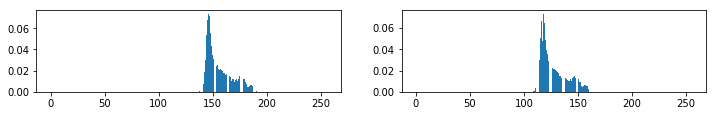

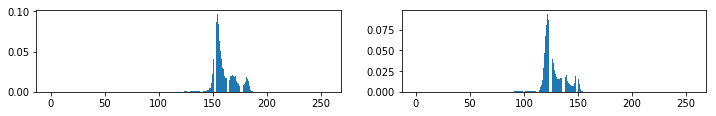

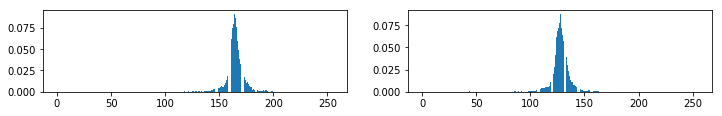

In [9]:
for path in paths_train[258:261]:
    fig, (ax_orig, ax_center) = plt.subplots(1, 2, figsize=(12, 1.5))
    
    hist_orig = extract_luminance_histogram(path)
    ax_orig.bar(range(len(hist_orig)), hist_orig)
    
    hist_center = extract_luminance_histogram(path, center=True)
    ax_center.bar(range(len(hist_center)), hist_center)
    
    plt.show()

In [10]:
def extract_luminance_histograms(paths, **kwargs):
    return np.array([extract_luminance_histogram(p, **kwargs) for p in paths])

In [11]:
%%time
# Warm up the cache
extract_luminance_histograms(paths_train)
None

CPU times: user 1min 3s, sys: 8.16 s, total: 1min 11s
Wall time: 1min 24s


In [12]:
# cloudpickle has trouble with @lru_cache (https://github.com/cloudpipe/cloudpickle/issues/178),
# so we'll use threading instead of the loki backend (which is process-based). The speedup isn't
# as great, but it's better than nothing.
from joblib import parallel_backend

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [14]:
from sklearn.preprocessing import FunctionTransformer
histogram_transformer = FunctionTransformer(extract_luminance_histograms, validate=False)

In [15]:
%%time
from sklearn.linear_model import SGDClassifier
y_pred_sgd = train_and_evaluate_model(make_pipeline(
    histogram_transformer,
    StandardScaler(),
    SGDClassifier(max_iter=1000, tol=1e-3),
))

Whole F1 = 0.88
CV F1 = 0.85 (±0.09)
All scores: array([0.90495435, 0.7936772 , 0.86601705])
CPU times: user 3.64 s, sys: 256 ms, total: 3.89 s
Wall time: 3.41 s


In [16]:
%%time
from sklearn.tree import DecisionTreeClassifier
with parallel_backend('threading'):
    y_pred_dt = train_and_evaluate_model(make_pipeline(
        histogram_transformer,
        DecisionTreeClassifier(),
    ))

Whole F1 = 1.00
CV F1 = 0.93 (±0.01)
All scores: array([0.93551519, 0.92520928, 0.92391761])
CPU times: user 18.1 s, sys: 614 ms, total: 18.7 s
Wall time: 10.2 s


In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier
y_pred_rf = train_and_evaluate_model(make_pipeline(
    histogram_transformer,
    RandomForestClassifier(n_estimators=10),
))

Whole F1 = 1.00
CV F1 = 0.96 (±0.01)
All scores: array([0.96501539, 0.9621547 , 0.95080124])
CPU times: user 5.09 s, sys: 116 ms, total: 5.21 s
Wall time: 5.23 s


**Conclusion**: The random forest has the best cross-validated performance by far, even though it appears to overfit the training set.

### Center histograms

Since the average color varies significantly between samples, shift each histogram so that the mean is at the center.

In [18]:
%%time
extract_luminance_histograms(paths_train, center=True)
None

CPU times: user 53.2 s, sys: 5.79 s, total: 59 s
Wall time: 59.1 s


In [19]:
centered_histogram_transformer = FunctionTransformer(
    extract_luminance_histograms,
    validate=False,
    kw_args=dict(center=True))

In [20]:
%%time
y_pred_sgd_center = train_and_evaluate_model(make_pipeline(
    centered_histogram_transformer,
    StandardScaler(),
    SGDClassifier(max_iter=1000, tol=1e-3),
))

Whole F1 = 0.95
CV F1 = 0.93 (±0.04)
All scores: array([0.95484237, 0.94192478, 0.90468772])
CPU times: user 3.09 s, sys: 232 ms, total: 3.32 s
Wall time: 2.77 s


In [21]:
%%time
with parallel_backend('threading'):
    y_pred_dt_center = train_and_evaluate_model(make_pipeline(
        centered_histogram_transformer,
        DecisionTreeClassifier(),
    ))

Whole F1 = 1.00
CV F1 = 0.93 (±0.00)
All scores: array([0.93601004, 0.93326069, 0.93396754])
CPU times: user 20.4 s, sys: 469 ms, total: 20.8 s
Wall time: 11.4 s


In [22]:
%%time
y_pred_rf_center = train_and_evaluate_model(make_pipeline(
    centered_histogram_transformer,
    RandomForestClassifier(n_estimators=10),
))

Whole F1 = 1.00
CV F1 = 0.96 (±0.01)
All scores: array([0.96480157, 0.96165028, 0.95708095])
CPU times: user 5.46 s, sys: 116 ms, total: 5.58 s
Wall time: 5.59 s


**Conclusion**: Centering improves the performance of the linear model, but decision tree models are able to do without it.

### Multilayer perceptron

In [23]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [24]:
def build_mlp_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(256,)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [25]:
from datetime import datetime

def create_log_dir(name):
    timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
    log_dir = f'logs/{name}-{timestamp}/'
    print(f'Using log_dir {log_dir}')
    return log_dir

In [31]:
%%time
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import TensorBoard, ModelCheckpoint

log_dir = create_log_dir('hist-gray-mlp')

y_pred_mlp = train_and_evaluate_model(
    make_pipeline(
        centered_histogram_transformer,
        StandardScaler(),
        KerasClassifier(build_mlp_model, epochs=20, verbose=0),
    ),
    # Silence during cross-validation, but reenable progress bars for whole-set training
    kerasclassifier__verbose=1,
    kerasclassifier__callbacks=[
        TensorBoard(log_dir),
        ModelCheckpoint(log_dir + '/checkpoint-{epoch:02d}-{loss:.2f}.hdf5'),
    ],
)

Using log_dir logs/hist-gray-mlp-20190616-191602/
Epoch 1/20
21807/21807 [==============================] - 2s 77us/step - loss: 0.1878 - acc: 0.9557
Epoch 2/20
21807/21807 [==============================] - 2s 70us/step - loss: 0.1737 - acc: 0.9600
Epoch 3/20
21807/21807 [==============================] - 1s 67us/step - loss: 0.1662 - acc: 0.9614
Epoch 4/20
21807/21807 [==============================] - 1s 63us/step - loss: 0.1594 - acc: 0.9620
Epoch 5/20
21807/21807 [==============================] - 1s 65us/step - loss: 0.1537 - acc: 0.9629
Epoch 6/20
21807/21807 [==============================] - 1s 65us/step - loss: 0.1415 - acc: 0.9623
Epoch 7/20
21807/21807 [==============================] - 1s 66us/step - loss: 0.1341 - acc: 0.9640
Epoch 8/20
21807/21807 [==============================] - 2s 72us/step - loss: 0.1292 - acc: 0.9637
Epoch 9/20
21807/21807 [==============================] - 1s 64us/step - loss: 0.1286 - acc: 0.9640
Epoch 10/20
21807/21807 [=========================

In [32]:
from sklearn.metrics import roc_curve

def plot_roc(ax, label, y_pred):
    fpr, tpr, _ = roc_curve(y_train, y_pred)
    ax.plot(fpr, tpr, linewidth=2, label=label)

def plot_rocs(ax, predictions, zoom=0):
    ax.plot([0, 1], [0, 1], "k--")
    ax.axis([0, 1 - zoom, zoom, 1])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    for label, y_pred in predictions.items():
        plot_roc(ax, label, y_pred)
    ax.legend(loc="lower right")

In [33]:
from sklearn.metrics import precision_recall_curve

def plot_prc(ax, label, y_pred):
    precisions, recalls, _ = precision_recall_curve(y_train, y_pred)
    ax.plot(recalls, precisions, linewidth=2, label=label)

def plot_prcs(ax, predictions, zoom=0):
    if ax is None:
        ax = plt.gca()
    ax.axis([zoom, 1, zoom, 1])
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    for label, y_pred in predictions.items():
        plot_prc(ax, label, y_pred)
    ax.legend(loc="lower left")

In [34]:
def plot_classification_curves(predictions, zoom=0):
    fig, (ax_roc, ax_prc) = plt.subplots(1, 2, figsize=(20, 10))
    plot_rocs(ax_roc, predictions, zoom)
    plot_prcs(ax_prc, predictions, zoom)

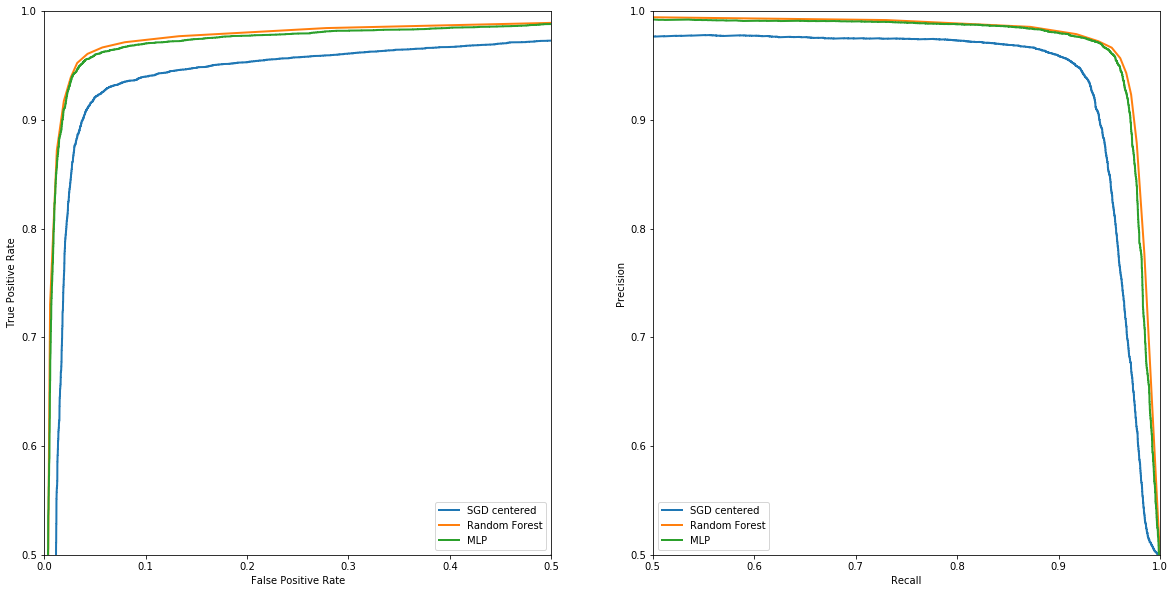

In [35]:
plot_classification_curves({
    "SGD centered": y_pred_sgd_center,
    "Random Forest": y_pred_rf,
    "MLP": y_pred_mlp,
}, zoom=0.5)

**Conclusion**: The performance of the multilayer perceptron has a high variance. After running it several times, I've noticed that it is sometimes better than the random forest, and sometimes middle-of-the-road. We should try regularizing or adding early stopping.

### Histogram in RGB

Instead of a 1D grayscale histogram, try a 3D RGB histogram to see if it helps the model zero in on any specific colors. The number of bins per dimension will have to be kept low (16) to avoid an explosion in the number of parameters, but the overall number of features will still be higher (4,096 vs. 296).

In [36]:
@lru_cache(maxsize=None)
def extract_rgb_histogram(path):
    image = imread(path)
    image = image.reshape((-1, 3))
    hist, _ = np.histogramdd(image, (16, 16, 16))
    hist = hist.ravel()
    return hist

In [37]:
def extract_rgb_histograms(paths):
    return np.array([extract_rgb_histogram(p) for p in paths])

In [38]:
%%time
# Warm up the cache
extract_rgb_histograms(paths_train)
None

CPU times: user 1min 42s, sys: 12.5 s, total: 1min 55s
Wall time: 2min 39s


In [39]:
rgb_histogram_transformer = FunctionTransformer(extract_rgb_histograms, validate=False)

In [40]:
%%time
from sklearn.linear_model import SGDClassifier
y_pred_sgd_rgb = train_and_evaluate_model(make_pipeline(
    rgb_histogram_transformer,
    StandardScaler(),
    SGDClassifier(max_iter=1000, tol=1e-3),
))

Whole F1 = 0.96
CV F1 = 0.93 (±0.00)
All scores: array([0.93293034, 0.93305439, 0.93526405])
CPU times: user 47.5 s, sys: 7.52 s, total: 55 s
Wall time: 58.7 s


In [41]:
%%time
from sklearn.ensemble import RandomForestClassifier
y_pred_rf_rgb = train_and_evaluate_model(make_pipeline(
    rgb_histogram_transformer,
    StandardScaler(),
    RandomForestClassifier(n_estimators=10),
))

Whole F1 = 1.00
CV F1 = 0.96 (±0.01)
All scores: array([0.96335964, 0.95346916, 0.95305951])
CPU times: user 24.5 s, sys: 8.14 s, total: 32.7 s
Wall time: 35 s


In [42]:
def build_rgb_mlp_model():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(4096,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [43]:
%%time

log_dir = create_log_dir('hist-rgb-mlp')

y_pred_mlp_rgb = train_and_evaluate_model(
    make_pipeline(
        rgb_histogram_transformer,
        StandardScaler(),
        KerasClassifier(build_rgb_mlp_model, epochs=20, verbose=0),
    ),
    kerasclassifier__verbose=1,
    kerasclassifier__callbacks=[
        TensorBoard(log_dir),
        ModelCheckpoint(log_dir + '/checkpoint-{epoch:02d}-{loss:.2f}.hdf5'),
    ],
)

Using log_dir logs/hist-rgb-mlp-20190616-192216/
Epoch 1/20
21807/21807 [==============================] - 13s 610us/step - loss: 0.2223 - acc: 0.9402
Epoch 2/20
21807/21807 [==============================] - 13s 574us/step - loss: 0.1735 - acc: 0.9547
Epoch 3/20
21807/21807 [==============================] - 14s 641us/step - loss: 0.1585 - acc: 0.9590
Epoch 4/20
21807/21807 [==============================] - 10s 478us/step - loss: 0.1497 - acc: 0.9611
Epoch 5/20
21807/21807 [==============================] - 13s 599us/step - loss: 0.1476 - acc: 0.9613
Epoch 6/20
21807/21807 [==============================] - 13s 586us/step - loss: 0.1422 - acc: 0.9648
Epoch 7/20
21807/21807 [==============================] - 13s 597us/step - loss: 0.1391 - acc: 0.9647
Epoch 8/20
21807/21807 [==============================] - 12s 555us/step - loss: 0.1337 - acc: 0.9658
Epoch 9/20
21807/21807 [==============================] - 11s 484us/step - loss: 0.1299 - acc: 0.9653
Epoch 10/20
21807/21807 [========

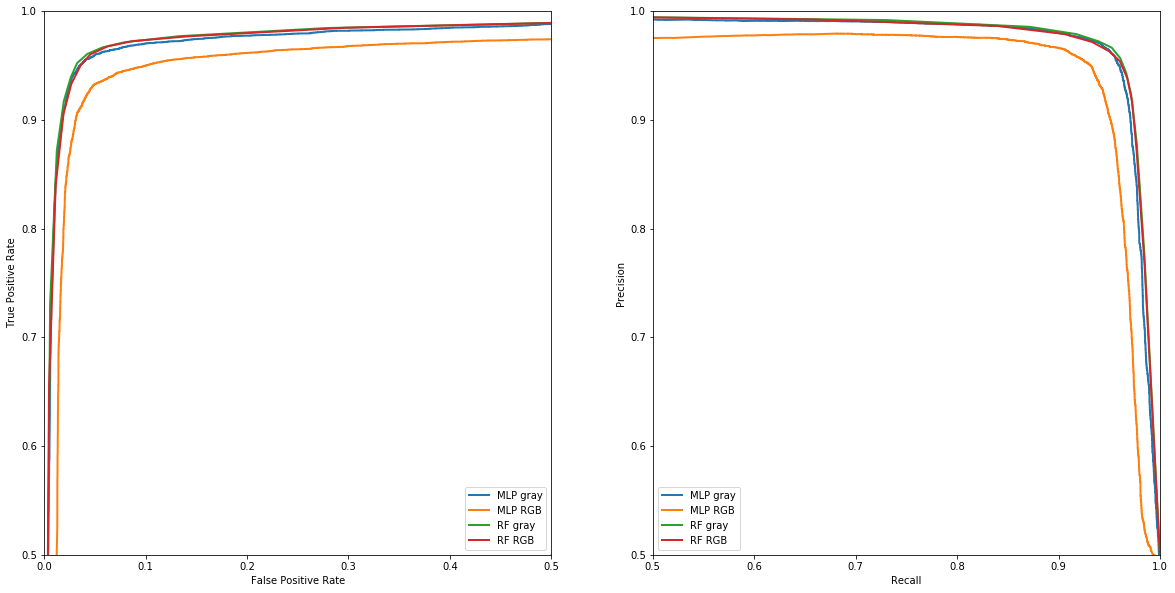

In [44]:
plot_classification_curves({
    "MLP gray": y_pred_mlp,
    "MLP RGB": y_pred_mlp_rgb,
    "RF gray": y_pred_rf,
    "RF RGB": y_pred_rf_rgb,
#     "SGD gray": y_pred_sgd_center,
#     "SGD RGB": y_pred_sgd_rgb,
}, zoom=0.5)

**Conclusion**: Using an RGB histogram makes no difference to the random forest model, and it degrades the MLP and linear models.

## Convolutional neural net

Now that we have a baseline in the random forest model, try the buzzword approach and see if it does any better.

### Standardization & augmentation

Keras's ImageDataGenerator is a good starting point, but it doesn't deal with a few issues:
 * The black border region should be ignored for color transformations and standardizing the image
 * For maximum fidelity, the image should be resized *after* it is rotated/translated
 * The built-in training/validation split doesn't handle groups

In [45]:
from malaria_images import make_image_loader, standardize_image, augment_image

In [46]:
def show_images(images, size=3, **imshow_kwargs):
    figsize = (size * len(images), size)
    _, axs = plt.subplots(1, len(images), figsize=figsize)
    for i, image in enumerate(images):
        axs[i].imshow(image, **imshow_kwargs)

In [47]:
def show_channel_images(images, size=3, **imshow_kwargs):
    channels = images[0].shape[2]
    for c in range(channels):
        channel_images = [img[:,:,c] for img in images]
        show_images(channel_images, size, **imshow_kwargs)

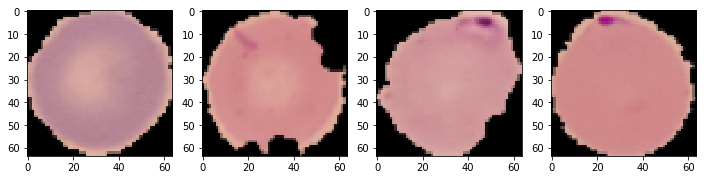

In [48]:
show_images([make_image_loader()(path) for path in paths_train[258:262]])

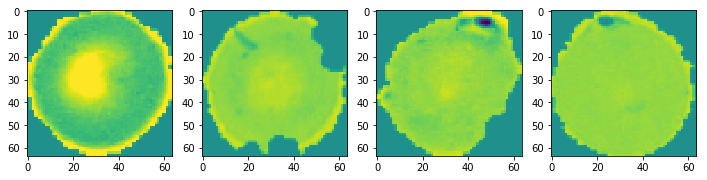

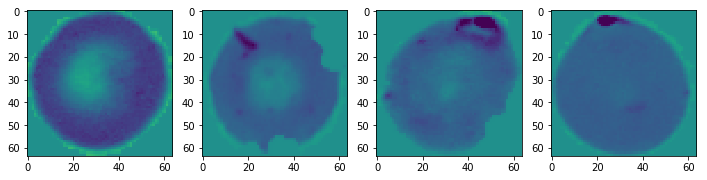

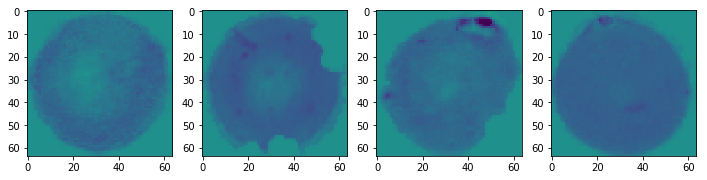

In [49]:
show_channel_images([make_image_loader(preprocess=standardize_image)(path) for path in paths_train[258:262]], vmin=-2, vmax=2)

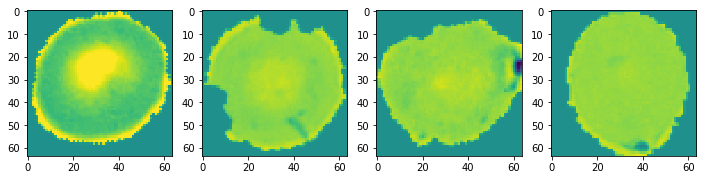

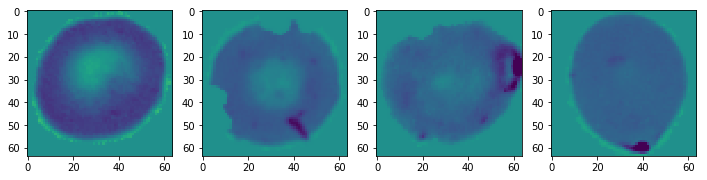

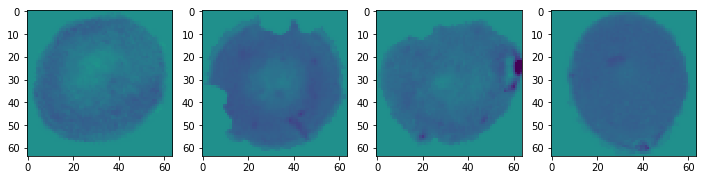

In [50]:
show_channel_images([make_image_loader(preprocess=augment_image)(path) for path in paths_train[258:262]], vmin=-2, vmax=2)

### Training

In [51]:
from keras.utils import Sequence

class LoaderSequence(Sequence):
    def __init__(self, params, y, batch_size, load_fn):
        self.params = params
        self.y = y
        self.batch_size = batch_size
        self.load_fn = load_fn

    def __len__(self):
        return int(np.ceil(len(self.y) / float(self.batch_size)))

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = start + self.batch_size
        batch_x = np.array([self.load_fn(item) for item in self.params[start:end]])
        batch_y = self.y[start:end]
        return batch_x, batch_y

In [52]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

def train_nn(build_model, name, batch_size=128, train_preprocess=None, validate_preprocess=None):
    if validate_preprocess is None:
        validate_preprocess = train_preprocess
    
    model = build_model()
    size = model.layers[0].input_shape[1]
    
    split = GroupShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
    train_idx, validate_idx = next(split.split(paths_train, y_train, groups=groups_train))
    train_data = LoaderSequence(
        paths_train[train_idx],
        y_train[train_idx],
        batch_size,
        make_image_loader(size, train_preprocess))
    validate_data = LoaderSequence(
        paths_train[validate_idx],
        y_train[validate_idx],
        batch_size,
        make_image_loader(size, validate_preprocess))

    log_dir = create_log_dir(name)

    history = model.fit_generator(
        train_data,
        validation_data=validate_data,
        epochs=25,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
            TensorBoard(log_dir),
            ModelCheckpoint(log_dir + '/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5'),
        ],
    )
    return model, history

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, SpatialDropout2D, Dropout, LeakyReLU, BatchNormalization
from keras.activations import relu

def build_cnn_model():
    model = Sequential([
        Conv2D(8, 3, dilation_rate=2, input_shape=(64, 64, 3)),
        LeakyReLU(0.01),
        MaxPooling2D(2),
        BatchNormalization(),
        #SpatialDropout2D(0.1),
        
        Conv2D(16, 3, dilation_rate=2),
        LeakyReLU(0.01),
        #MaxPooling2D(2),
        BatchNormalization(),
        #SpatialDropout2D(0.1),
        
        Conv2D(20, 3, dilation_rate=2),
        LeakyReLU(0.01),
        #MaxPooling2D(2),
        BatchNormalization(),
        #SpatialDropout2D(0.1),
        
        Conv2D(24, 3, dilation_rate=2),
        LeakyReLU(0.01),
        MaxPooling2D(2),
        BatchNormalization(),
        #SpatialDropout2D(0.1),
        
        Conv2D(32, 3, dilation_rate=2),
        LeakyReLU(0.01),
        #MaxPooling2D(2),
        BatchNormalization(),
        #SpatialDropout2D(0.1),
        
        Conv2D(40, 3, dilation_rate=2),
        LeakyReLU(0.01),
        #MaxPooling2D(2),
        BatchNormalization(),
        #SpatialDropout2D(0.1),
        
        Flatten(),
        
        Dense(64),
        LeakyReLU(0.01),
        Dropout(0.1),
        
        Dense(16),
        LeakyReLU(0.01),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [54]:
build_cnn_model().summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 8)         224       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 60, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 8)         32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        1168      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 26, 26, 16)        0         
___________________________

In [ ]:
cnn_model, cnn_history = train_nn(
    build_cnn_model,
    'cnn-64-augment',
    batch_size=64,
    train_preprocess=augment_image,
    validate_preprocess=standardize_image)

In [55]:
def predict_nn(model, batch_size=128, preprocess=None):
    size = model.layers[0].input_shape[1]
    load_image = make_image_loader(size, preprocess)
    X_train = LoaderSequence(paths_train, y_train, batch_size, load_image)
    y_pred = model.predict_generator(X_train)
    return y_pred[:,0]

In [ ]:
%%time
y_pred_cnn = predict_nn(cnn_model, preprocess=standardize_image)

### Best model

In [56]:
from keras.models import load_model
cnn_model_best = load_model('logs/cnn-64-augment-20190608-123948/checkpoint-19-0.12.hdf5')

In [57]:
%%time
y_pred_cnn_best = predict_nn(cnn_model_best, preprocess=standardize_image)

CPU times: user 8min 23s, sys: 1min 14s, total: 9min 37s
Wall time: 4min 41s


## Histogram vs. CNN

**NOTE**: This comparison isn't completely valid, because the predictions from the histogram model are from cross-validation, while the CNN model was trained on a single training set.

It would take some work to get the CNN working well as a scikit-learn classifier because:
 * It requires out-of-core learning, which `KerasClassifier` could support, but doesn't.
 * Early stopping is harder to achieve with scikit-learn's cross-validation functions because we need to group by patient, so we can't just use the `validation_split` parameter on `Sequential.fit()`.

In [58]:
import sklearn.metrics as metrics
from textwrap import dedent

def print_metrics(y_pred, threshold=None):
    if threshold is not None:
        y_pred = y_pred >= threshold
    print(dedent(f"""
        prec.:    {metrics.precision_score(y_train, y_pred):.3f}
        recall:   {metrics.recall_score(y_train, y_pred):.3f}
        accuracy: {metrics.accuracy_score(y_train, y_pred):.3f}
        ROC AUC:  {metrics.roc_auc_score(y_train, y_pred):.3f}
        MCC:      {metrics.matthews_corrcoef(y_train, y_pred):.3f}
        F1:       {metrics.f1_score(y_train, y_pred):.3f}
        confusion:"""))
    print(metrics.confusion_matrix(y_train, y_pred))

In [59]:
print_metrics(y_pred_rf, 0.5)


prec.:    0.957
recall:   0.961
accuracy: 0.959
ROC AUC:  0.959
MCC:      0.918
F1:       0.959
confusion:
[[10508   470]
 [  425 10404]]


In [60]:
print_metrics(y_pred_mlp, 0.5)


prec.:    0.965
recall:   0.949
accuracy: 0.957
ROC AUC:  0.957
MCC:      0.915
F1:       0.957
confusion:
[[10604   374]
 [  557 10272]]


In [61]:
print_metrics(y_pred_cnn_best, 0.5)


prec.:    0.962
recall:   0.961
accuracy: 0.962
ROC AUC:  0.962
MCC:      0.923
F1:       0.961
confusion:
[[10569   409]
 [  427 10402]]


### Voting classifier

Try a soft-voting classifier combining the random forest and CNN models with equal weights. Again, this isn't completely valid because the CNN predictions aren't cross-validated. This is just a preliminary test.

In [62]:
y_pred_soft_voting = (y_pred_cnn_best + y_pred_rf) / 2.0

In [63]:
print_metrics(y_pred_soft_voting, 0.5)


prec.:    0.966
recall:   0.963
accuracy: 0.965
ROC AUC:  0.965
MCC:      0.930
F1:       0.965
confusion:
[[10614   364]
 [  400 10429]]


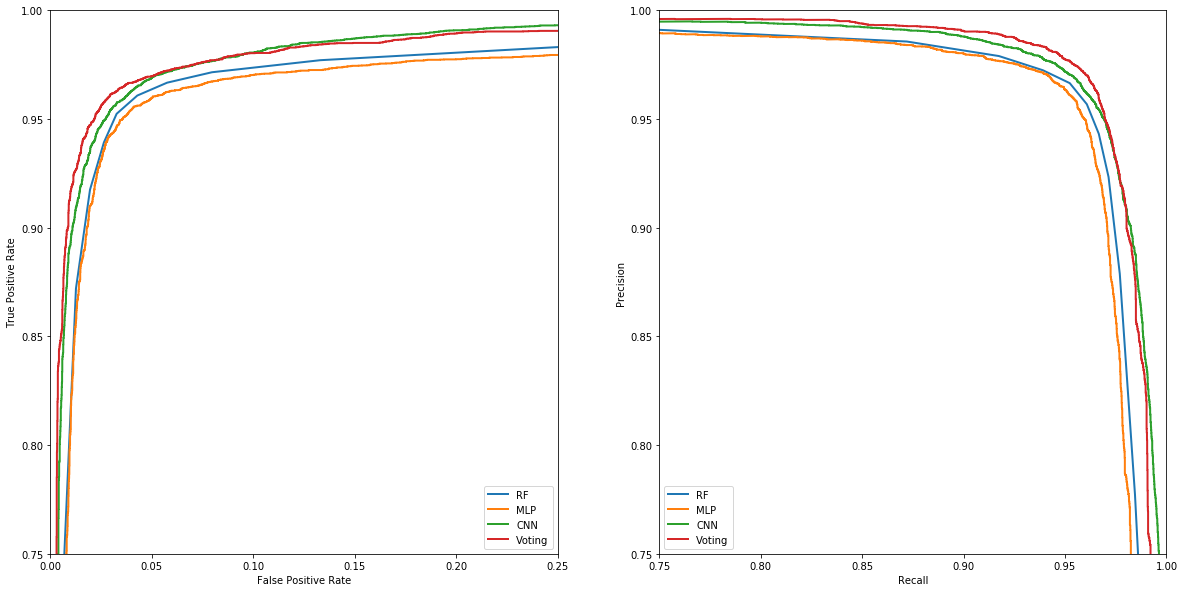

In [64]:
plot_classification_curves({
    "RF": y_pred_rf,
    "MLP": y_pred_mlp,
    "CNN": y_pred_cnn_best,
    "Voting": y_pred_soft_voting,
}, zoom=0.75)

### Error Analysis

In [65]:
from math import sqrt, ceil
import matplotlib.gridspec as gridspec

def plot_square(fig, subplot_spec, label, images):
    s = ceil(sqrt(len(images)))
    
    # Add axes just for the title
    fig.add_subplot(subplot_spec, title=label, frame_on=False, xticks=[], yticks=[])
    
    inner_grid = gridspec.GridSpecFromSubplotSpec(s, s, subplot_spec=subplot_spec)
    for i, image in enumerate(images):
        ax = plt.Subplot(fig, inner_grid[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(image)
        fig.add_subplot(ax)

def plot_errors(y_train, y_pred, title=None, threshold = None):
    if threshold is not None:
        y_pred = y_pred >= threshold
    confusion = [
        ('True Positive',  paths_train[(y_train == True ) & (y_pred == True )]),
        ('False Positive', paths_train[(y_train == False) & (y_pred == True )]),
        ('False Negative', paths_train[(y_train == True ) & (y_pred == False)]),
        ('True Negative',  paths_train[(y_train == False) & (y_pred == False)]),
    ]
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(title, size=20)
    outer_grid = gridspec.GridSpec(2, 2)
    for i, (label, paths) in enumerate(confusion):
        plot_square(fig, outer_grid[i], label, [imread(image) for image in paths[:25]])

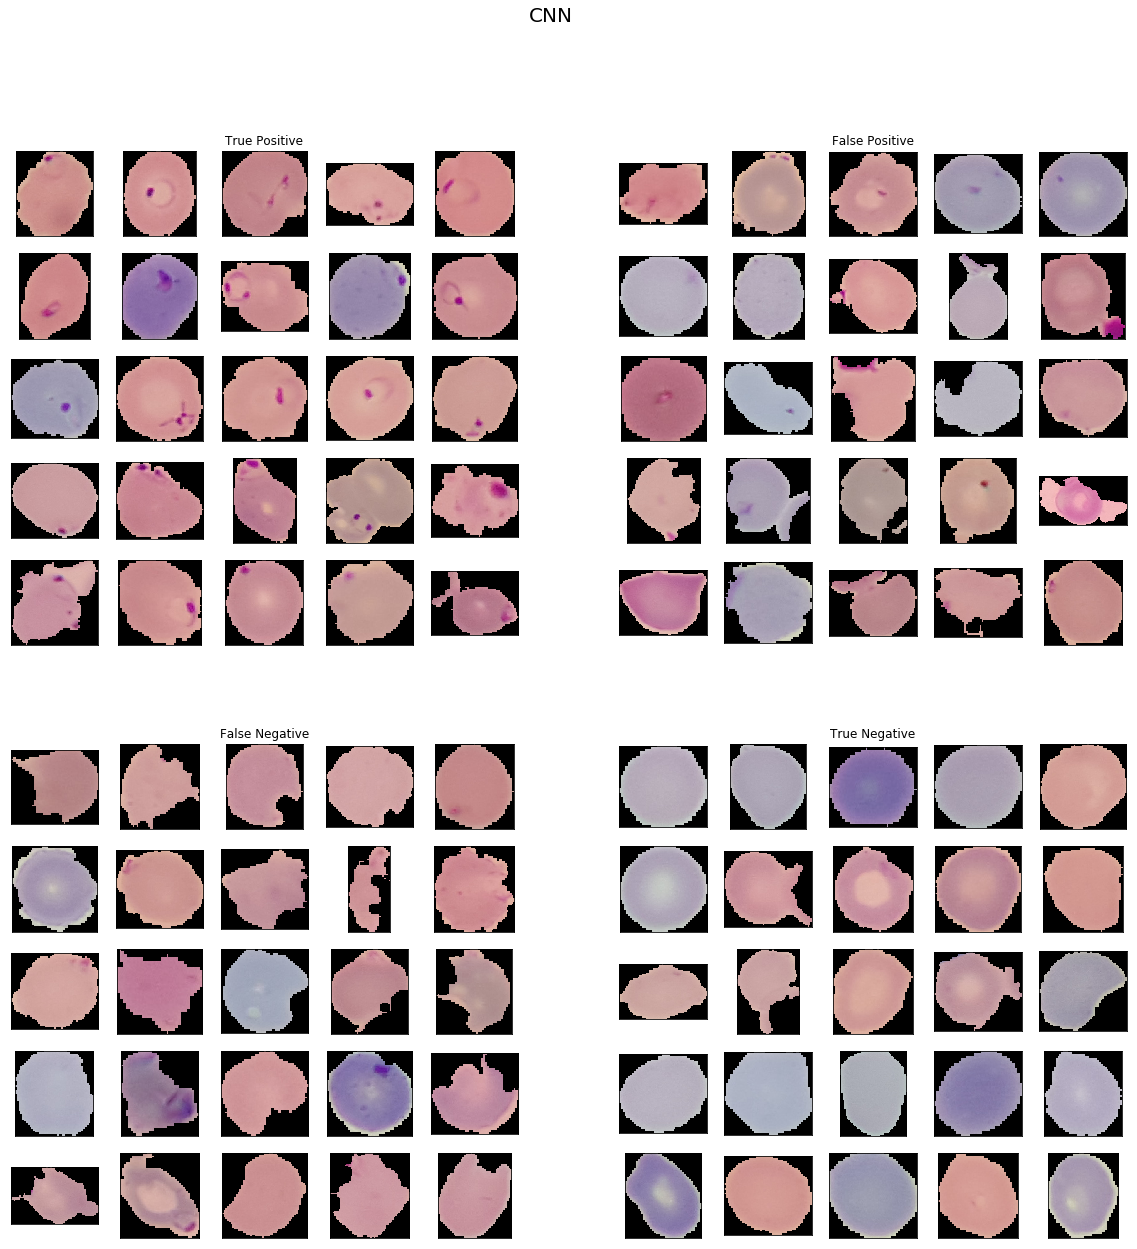

In [66]:
plot_errors(y_train, y_pred_cnn_best, "CNN", 0.5)

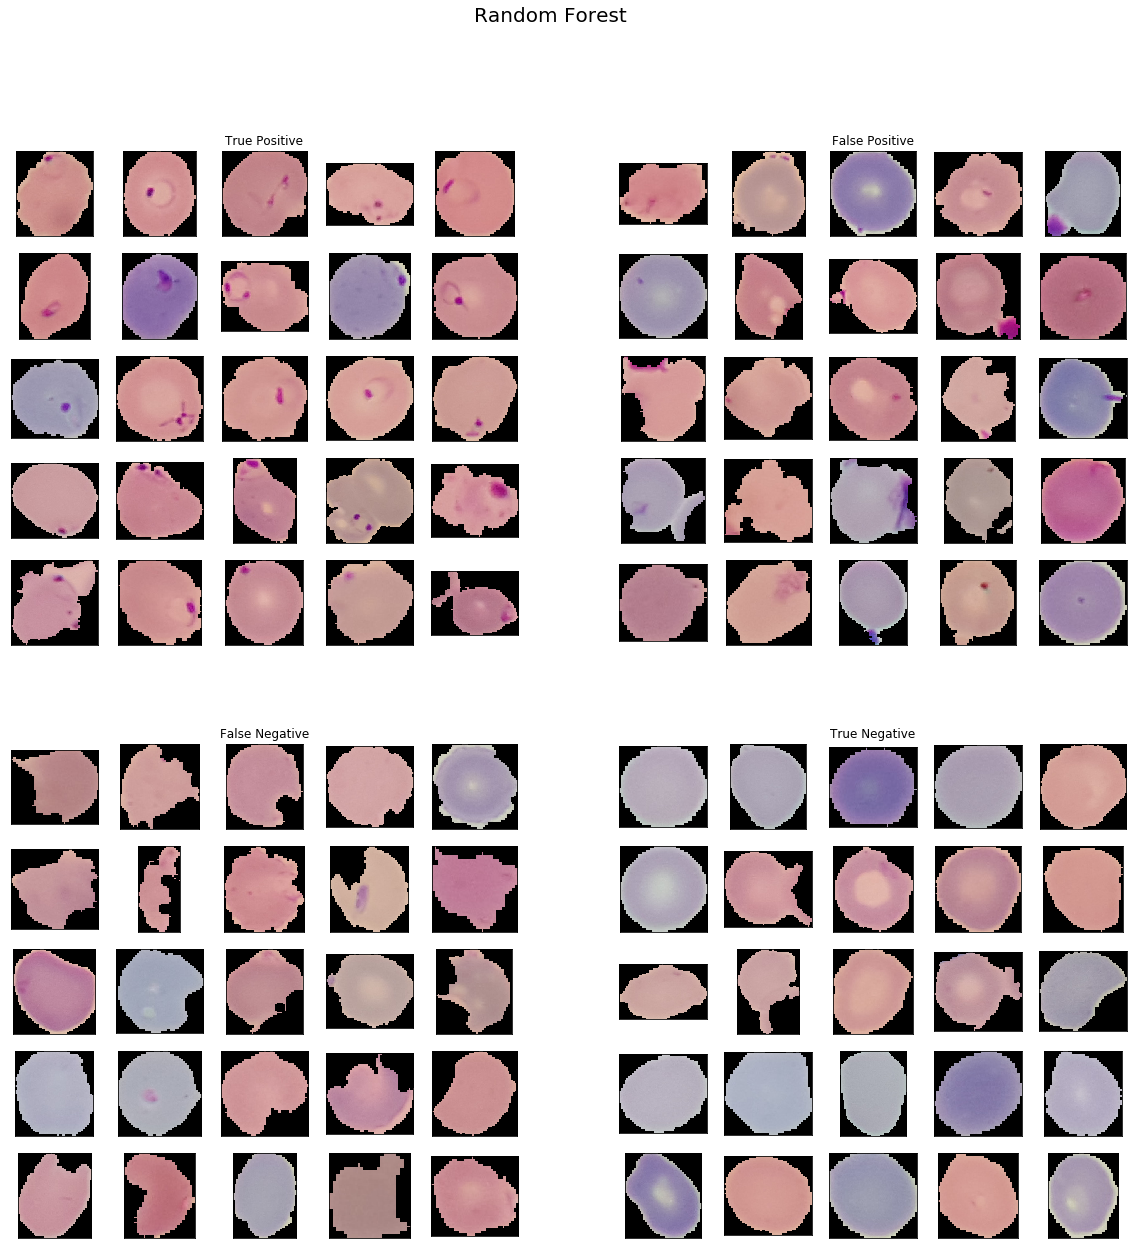

In [67]:
plot_errors(y_train, y_pred_rf, "Random Forest", 0.5)

## Conclusions

The convlutional neural net appears slightly better than the random forest model, but this is difficult to say without cross-validating (which would take some work) or evaluating on the test set (which I'm not ready to commit to yet). The CNN has higher scores in recall, precision, $F_1$, MCC, and ROC AUC.

The MLP model has a high variance, and sometimes it is better than the random forest or CNN. We should make some attempts at regularizing it to see if we can get more consistent results.

An equal-weight soft-voting classifier appears to have better recall than either model, at the expense of precision. Overall scores are lower than the CNN. It might be worth experimenting with different weights.

Looking at the errors made by both models, it's hard to say how to improve. Some of the false positives are clearly anomalies that the CNN could distinguish in principle: large blotches without the characteristic rings seen in the true positives. We might be able to get the CNN to pick these up by widening its aperture with a larger kernel size or dilation rate.

However, as a non-expert, some of the false positives are indistinguishable from true positives to me. Similarly, some of the false negatives from the CNN model look completely featureless—even more than some of the true negatives—so I'm suspicious about the quality of the labeling. The original paper explains some of the methodology they used to segment and label the cells, but it was short on details and data for that part of the process.

### Todo

* Other GLMs
* CIE LAB
* Regularize MLP
* CNN
  * Cross-validate
  * More image augmentation
  * Other activations
  * Other kernel size/dilation/stride/pooling schemes
* Find voting weights by CV
* Evaluate metrics at patient & slide level
* **Evaluate on test set** (last)